In [1]:
import random
from causal.causal_model_causal_non_causal import CausalModelCBN
# Initialize the random seed with the current system time
random.seed(2713)
print("dice: ", random.random())

model = CausalModelCBN()

dice:  0.47979348839988334
Set edges by user
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
successful_combinations 1
Lerne Modell mit exhaustive-Algorithmus und K2-Score


### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [2]:
from causal.causal_model_causal_non_causal import CausalModelCBN
from plan.GifflerThompson import GifflerThompson
from factory.Operation import Operation
from generators.jobs_data_generator import JobsDataGenerator
from plan.PriorityRules import calculate_dynamic_priority, calculate_fcfs_priority

# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]

# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
#model = CausalModel(csv_file=csv_file)
#model = CausalModelPyMC(csv_file=csv_file)
model = CausalModelCBN()
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])
    #observed_data.append([len(operation.predecessor_operations), operation.req_machine_group_id, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)


Set edges by user
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
successful_combinations 1
Lerne Modell mit exhaustive-Algorithmus und K2-Score


In [3]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

2100
1890
2130
2805
4440
2325
2250
2340
3195
4545
2580
2655
2700
3555
4680
2895
2925
2970
3975
4755
3180
4290
3300
4335
3585
3375
3645
4800
4920
3900
5130
3960
5175
15
60
75
105
360
315
390
555
3900
585
720
765
915
4035
840
1080
1125
1290
4155
1185
1260
1305
1725
4215
1560
1485
1620
2115
4275
1635
1530
1665
2145
4290
1650
2175
1680
2220
1695
1575
1710
2220
4305
1710
1620
1725
2250
4320
1725
1665
1740
2280
4335
1740
1710
1755
2310
4350
1755
2340
1785
2385
1800
2385
1830
2430
1845
2430
1875
2475
1890
1755
1935
2475
4365
1905
1800
1950
2505
4380
1920
2535
1950
2580
1965
2580
1995
2640
2010
2625
2040
2670
2055
2670
2085
2715
2115
1845
2145
2715
4395
2130
1935
2160
2745
4410
2145
1980
2175
2775
4425
2160
2835
2190
2880
2205
2025
2235
2880
4455
2220
2070
2250
2910
4470
2235
2115
2265
2940
4485
2250
2160
2280
2970
4500
2265
3000
2295
3045
2310
2205
2325
3045
4515
2340
3075
2370
3120
2385
3120
2415
3180
2430
2295
2490
3165
4530
2445
3225
2475
3270
2490
2340
2505
3270
4560
2505
2385
2520
3300
4

## Some statistics to compare the plan

In [4]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1792.3 time units
Causal | 1935.68 time units
Sim | 1960.78 time units


In [36]:
import math

truth_sim = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])
truth_causal = pd.DataFrame([op.to_dict() for op in gt_causal_schedule])

combined_df = pd.merge(truth_sim, truth_causal, on=['job_id', 'operation_id'], how='outer')

#trouth_sim['diff'] = trouth_sim['duration'] - trouth_sim['plan_duration']
#trouth_causal['diff'] = trouth_causal['plan_duration'] - trouth_causal['duration']
#trouth_sim['sim_causal_dif'] = trouth_causal['plan_duration'] - trouth_sim['duration']


combined_df['diff_sim_truth'] = combined_df['duration_x'] - combined_df['plan_duration_x']
combined_df['diff_causal_truth'] = combined_df['plan_duration_y'] - combined_df['duration_y']
combined_df['diff_causal_sim'] = combined_df['duration_x'] - combined_df['plan_duration_y'] 
combined_df[['duration_x','plan_duration_x', 'diff_sim_truth', 'diff_sim_truth', 'diff_causal_sim']].describe()
# combined_df[combined_df['diff_causal_sim'] > 0].head(1000)



,duration_x,plan_duration_x,diff_sim_truth,diff_sim_truth,diff_causal_sim
count,684.000000,684.000000,684.000000,684.000000,684.000000
mean,27.175439,24.868421,2.307018,2.307018,0.017544
std,13.675006,12.228795,3.001104,3.001104,3.761909
min,15.000000,15.000000,0.000000,0.000000,-9.000000
25%,15.000000,15.000000,0.000000,0.000000,0.000000
50%,18.000000,15.000000,0.000000,0.000000,0.000000
75%,36.000000,30.000000,3.000000,3.000000,0.000000
max,54.000000,45.000000,9.000000,9.000000,9.000000


In [4]:
# df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'operation_duration'])
# df_observed_data.to_csv("data/observed_data.csv")

Sim result

/tmp/ipykernel_305853/1685830134.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


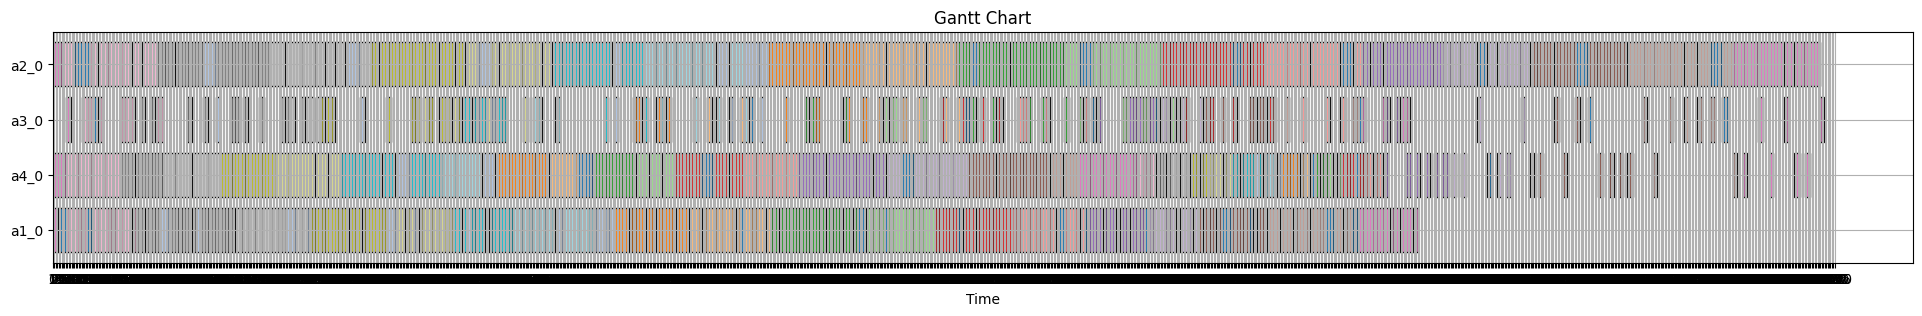

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen (optional, falls du das möchtest)
    # ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))

# Grid anzeigen
ax.grid(True)

# Diagramm anzeigen
plt.show()

GT without causal

/tmp/ipykernel_305853/1553617269.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


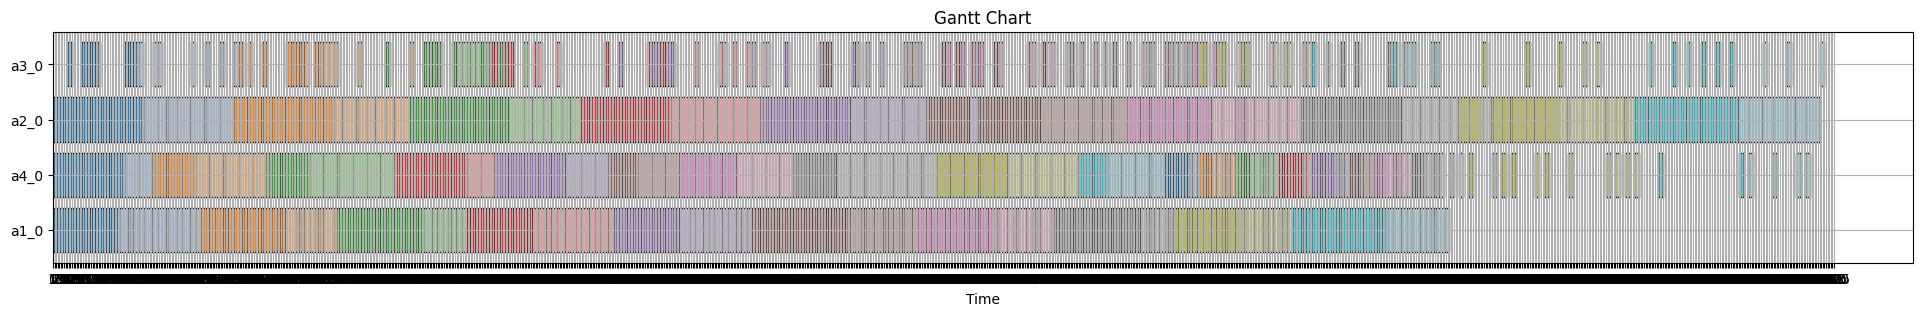

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_non_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

/tmp/ipykernel_305853/873938610.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


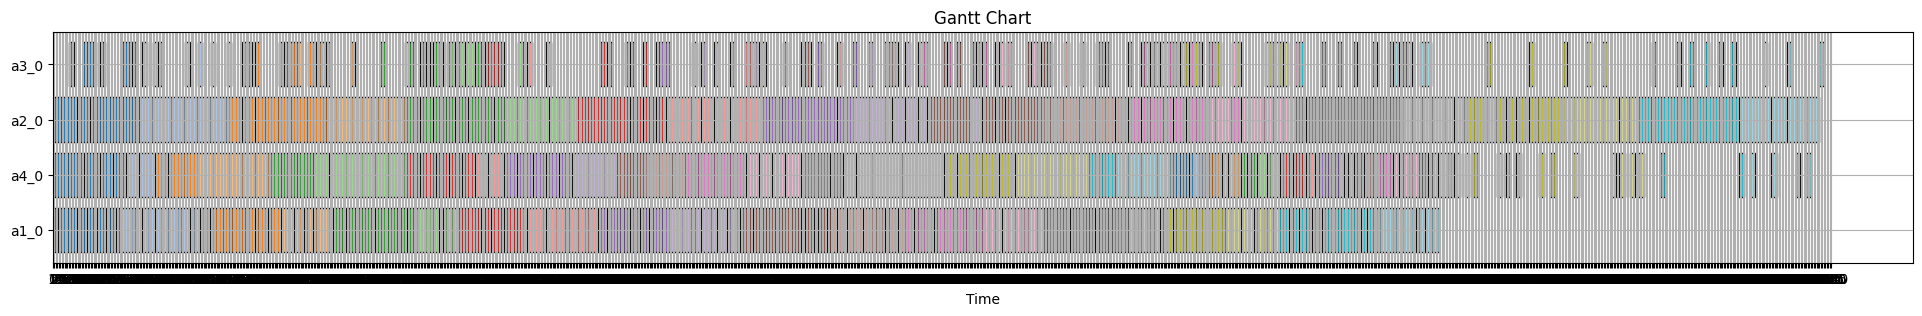

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]
    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
